In [81]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [82]:
train_set =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 10_000_000)
test_set =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

In [83]:
train_set.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [84]:
train_set.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


In [85]:
train_set.dtypes[train_set.dtypes != 'object']

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [86]:
# plt.scatter(x='pickup_longitude', y='fare_amount', data=train_set)

In [87]:
#მერიდიანი -180, +180 ზე მეტ მნიშვნელობას ვერ იღებს. გადასყრელია სხვები
train_set = train_set[train_set['pickup_longitude'] >= -180]
# plt.scatter(x='pickup_longitude', y='fare_amount', data=train_set)

In [88]:
train_set = train_set[train_set['pickup_longitude'] <= 180]
# plt.scatter(x='pickup_longitude', y='fare_amount', data=train_set)

In [89]:
train_set.query('pickup_longitude == 0 & fare_amount > 1200')
#შეიძლება დადროპვა 2015-03-09 15:12:00.0000002

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
1144706,2015-03-09 15:12:00.0000002,1273.31,2015-03-09 15:12:00 UTC,0.0,0.0,0.0,0.0,1


In [90]:
# plt.scatter(x='pickup_latitude', y='fare_amount', data=train_set)

In [91]:
#განედი -90, +90 ზე მეტ მნიშვნელობას ვერ იღებს. გადასყრელია სხვები
train_set = train_set[train_set['pickup_latitude'] >= -90]
train_set = train_set[train_set['pickup_latitude'] <= 90]
# plt.scatter(x='pickup_latitude', y='fare_amount', data=train_set)

In [92]:
#განედი -90, +90 ზე მეტ მნიშვნელობას ვერ იღებს. გადასყრელია სხვები
train_set = train_set[train_set['dropoff_latitude'] >= -90]
train_set = train_set[train_set['dropoff_latitude'] <= 90]
# plt.scatter(x='dropoff_latitude', y='fare_amount', data=train_set)

In [93]:
#მერიდიანი -180, +180 ზე მეტ მნიშვნელობას ვერ იღებს. გადასყრელია სხვები
train_set = train_set[train_set['dropoff_longitude'] >= -180]
train_set = train_set[train_set['dropoff_longitude'] <= 180]
# plt.scatter(x='dropoff_longitude', y='fare_amount', data=train_set)

In [94]:
z_scores = stats.zscore(train_set['dropoff_longitude'])

top_10_indices = np.argsort(z_scores)[-10:]

top_10_rows = train_set.iloc[top_10_indices]

print(top_10_rows)
#ამათი zscore არის ყველაზე მეტად აწეული, ბოლო 2ის განსაკუთრებით, შეიძლება გადაყრა
#2013-03-11 15:33:00.00000076
#2010-07-13 19:30:00.00000027
#2009-08-23 02:43:00.000000132
#2010-04-09 10:18:23.0000001 
#2014-08-12 15:46:13.0000002

                                   key  fare_amount          pickup_datetime  \
7476273  2013-05-24 23:56:00.000000115        39.00  2013-05-24 23:56:00 UTC   
1294009   2013-05-23 20:16:00.00000081        47.94  2013-05-23 20:16:00 UTC   
3008504   2013-05-25 20:47:00.00000097        35.94  2013-05-25 20:47:00 UTC   
6998648  2013-05-23 09:14:00.000000245        55.83  2013-05-23 09:14:00 UTC   
793922     2012-06-03 11:19:37.0000002        32.10  2012-06-03 11:19:37 UTC   
3513478   2013-03-11 15:33:00.00000076         4.00  2013-03-11 15:33:00 UTC   
9200265   2010-07-13 19:30:00.00000027         5.30  2010-07-13 19:30:00 UTC   
4285915  2009-08-23 02:43:00.000000132        20.90  2009-08-23 02:43:00 UTC   
7513372    2010-04-09 10:18:23.0000001         9.30  2010-04-09 10:18:23 UTC   
9314508    2014-08-12 15:46:13.0000002         4.00  2014-08-12 15:46:13 UTC   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
7476273         40.753977       -73.981673          40

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


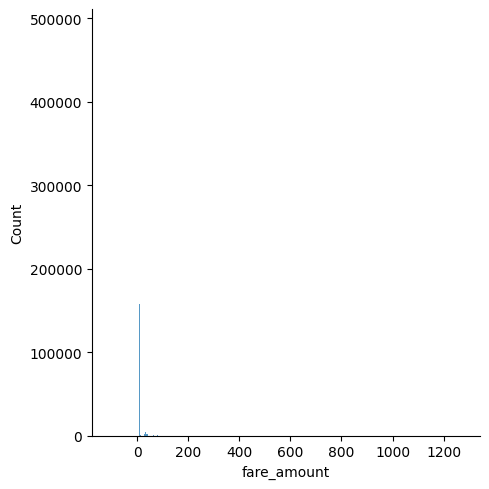

In [95]:
sns.displot(train_set["fare_amount"], kde = False);

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


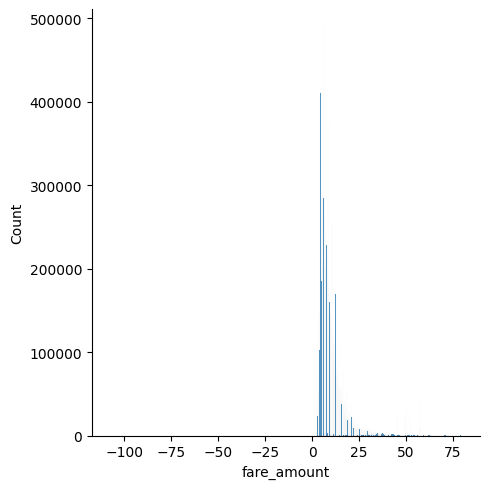

In [96]:
sns.displot(train_set[train_set["fare_amount"] < 80]["fare_amount"], kde = False);

In [97]:
#უარყოფითი ვერ იქნება გადასახადი
train_set = train_set[train_set["fare_amount"] >= 0]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


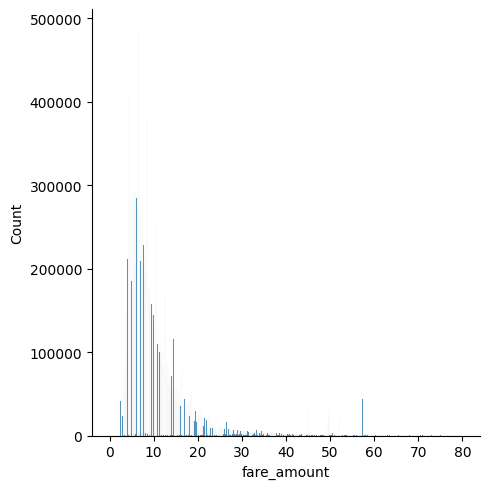

In [98]:
sns.displot(train_set[train_set["fare_amount"] < 80]["fare_amount"], kde = False);

In [99]:
train_set.query('fare_amount > 57 & fare_amount < 58')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
286,2013-06-14 17:37:00.00000037,57.33,2013-06-14 17:37:00 UTC,-73.781127,40.645007,-73.981802,40.762515,1
437,2014-05-12 23:31:00.00000042,57.33,2014-05-12 23:31:00 UTC,-73.790250,40.643705,-74.002270,40.734542,1
622,2014-11-18 09:19:00.000000211,57.33,2014-11-18 09:19:00 UTC,-73.776720,40.645412,-73.978832,40.774932,1
690,2014-09-30 16:13:00.00000021,57.33,2014-09-30 16:13:00 UTC,-74.007750,40.741277,-73.790292,40.646760,2
737,2014-08-11 19:37:00.000000174,57.33,2014-08-11 19:37:00 UTC,-73.776477,40.646290,-73.776477,40.646290,2
...,...,...,...,...,...,...,...,...
9999533,2015-01-09 16:07:38.0000005,57.33,2015-01-09 16:07:38 UTC,-73.788849,40.642593,-73.973785,40.792259,4
9999545,2013-12-06 10:49:00.000000173,57.33,2013-12-06 10:49:00 UTC,-73.993805,40.758815,-73.784982,40.643170,6
9999594,2014-02-21 09:37:11.0000003,57.33,2014-02-21 09:37:11 UTC,-74.014818,40.715558,-73.782555,40.648808,1
9999772,2014-11-02 23:31:00.00000039,57.33,2014-11-02 23:31:00 UTC,-73.924830,40.735742,-73.983987,40.761072,1


In [100]:
print(train_set.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [101]:

#გამოვრიცხოთ არა ნიუ იორკის კოორდინატები
#Maximum Latitude: Around 40.9176° North
# Minimum Latitude: Around 40.4774° North
# Maximum Longitude: Around -73.7004° West
# Minimum Longitude: Around -74.2591° West


b = (-74.26, -73.7, 40.48, 40.92)

def in_NYC(s):
    return (s.pickup_longitude >= b[0]) & (s.pickup_longitude <= b[1]) & \
           (s.pickup_latitude >= b[2]) & (s.pickup_latitude <= b[3]) & \
           (s.dropoff_longitude >= b[0]) & (s.dropoff_longitude <= b[1]) & \
           (s.dropoff_latitude >= b[2]) & (s.dropoff_latitude <= b[3])

print('Old size: %d' % len(train_set))
train_set = train_set[in_NYC(train_set)]
print('New size: %d' % len(train_set))

Old size: 9999035
New size: 9775985


In [102]:
# sns.displot(train_set[train_set["fare_amount"] < 80]["fare_amount"], kde = False);

In [103]:
import math
from math import sin, cos, sqrt, atan2, radians

#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

def distance(lat1, lon1, lat2, lon2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance


train_set["distance"] = distance(train_set["pickup_latitude"], train_set["pickup_longitude"], train_set["dropoff_latitude"], train_set["dropoff_longitude"])
print(train_set)

                                   key  fare_amount          pickup_datetime  \
0          2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1          2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2         2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3          2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4        2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   
...                                ...          ...                      ...   
9999995  2012-08-12 01:18:00.000000208          5.7  2012-08-12 01:18:00 UTC   
9999996  2013-08-07 10:28:00.000000147          5.5  2013-08-07 10:28:00 UTC   
9999997   2013-10-29 08:29:00.00000082         14.0  2013-10-29 08:29:00 UTC   
9999998    2012-04-07 16:41:33.0000004         10.5  2012-04-07 16:41:33 UTC   
9999999   2010-03-30 19:27:00.00000066          8.5  2010-03-30 19:27:00 UTC   

         pickup_longitude  pickup_latit

In [104]:

# plt.scatter(x='distance', y='fare_amount', data=train_set)

In [105]:
train_set.query('fare_amount > 540')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
3206977,2015-02-03 14:50:22.0000003,542.83,2015-02-03 14:50:22 UTC,-73.863289,40.769989,-73.959152,40.762569,1,8.117892
4894706,2015-02-09 15:22:07.00000013,952.00,2015-02-09 15:22:07 UTC,-73.996712,40.757793,-73.782890,40.643925,2,22.034602
6979398,2015-05-01 03:40:24.0000001,850.00,2015-05-01 03:40:24 UTC,-74.028641,40.759911,-74.028641,40.759911,2,0.000000


In [106]:
train_set_copy = train_set.copy()

train_set_copy.drop(train_set_copy[train_set_copy['fare_amount'] > 540].index, inplace=True)

train_set = train_set_copy
# plt.scatter(x='distance', y='fare_amount', data=train_set)

In [107]:
train_set.query('distance > 2 & fare_amount>400')
train_set_copy = train_set.copy()

train_set_copy.drop(train_set_copy[(train_set_copy['fare_amount'] > 400) & (train_set_copy['distance'] > 2)].index, inplace=True)

train_set = train_set_copy
# plt.scatter(x='distance', y='fare_amount', data=train_set)

In [108]:
train_set.query('distance > 9 & fare_amount>220')

train_set_copy = train_set.copy()

train_set_copy.drop(train_set_copy[(train_set_copy['fare_amount'] > 220) & (train_set_copy['distance'] > 9)].index, inplace=True)

train_set = train_set_copy
# plt.scatter(x='distance', y='fare_amount', data=train_set)

In [109]:

train_set = train_set.drop(((train_set[train_set['distance']==0])).index, axis=0)
# plt.scatter(x='distance', y='fare_amount', data=train_set)

In [110]:
train_set['pickup_datetime'] = pd.to_datetime(train_set['pickup_datetime'])
train_set['day'] = train_set['pickup_datetime'].dt.dayofweek
train_set['month'] = train_set['pickup_datetime'].dt.month
train_set['hour'] = train_set['pickup_datetime'].dt.hour

In [111]:
# plt.scatter(x='passenger_count', y='fare_amount', data=train_set)

In [112]:

train_set_copy = train_set.copy()

train_set_copy.drop(train_set_copy[(train_set_copy['passenger_count'] <= 0)].index, inplace=True)
train_set_copy.drop(train_set_copy[(train_set_copy['passenger_count'] > 10)].index, inplace=True)

                                   
train_set = train_set_copy
# plt.scatter(x='passenger_count', y='fare_amount', data=train_set)

In [113]:
train_set.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,day,month,hour
count,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06,9.640956e+06
mean,1.129383e+01,-7.397564e+01,4.075088e+01,-7.397477e+01,4.075125e+01,1.690848e+00,3.340535e+00,3.041410e+00,6.268880e+00,1.351310e+01
std,9.410304e+00,3.415202e-02,2.674776e-02,3.351901e-02,3.063296e-02,1.306393e+00,3.554711e+00,1.949245e+00,3.436452e+00,6.515918e+00
min,0.000000e+00,-7.425999e+01,4.048132e+01,-7.425990e+01,4.048034e+01,1.000000e+00,8.406083e-05,0.000000e+00,1.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399230e+01,4.073658e+01,-7.399159e+01,4.073561e+01,1.000000e+00,1.278447e+00,1.000000e+00,3.000000e+00,9.000000e+00
50%,8.500000e+00,-7.398213e+01,4.075336e+01,-7.398065e+01,4.075388e+01,1.000000e+00,2.176045e+00,3.000000e+00,6.000000e+00,1.400000e+01
75%,1.250000e+01,-7.396849e+01,4.076752e+01,-7.396558e+01,4.076839e+01,2.000000e+00,3.937208e+00,5.000000e+00,9.000000e+00,1.900000e+01
max,5.000000e+02,-7.370000e+01,4.091955e+01,-7.370000e+01,4.091995e+01,9.000000e+00,4.565809e+01,6.000000e+00,1.200000e+01,2.300000e+01


In [114]:
# corr_matrix = train_set.corr()
# corr_matrix["fare_amount"].sort_values(ascending=False)

In [115]:
X = train_set[['passenger_count', 'distance', 'day', 'month', 'hour']]
y = train_set['fare_amount']


X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=0)



In [116]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [117]:
model.score(X_dev, y_dev)

0.7732384504569333

In [118]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X, y, cv=5).mean()

0.7728924013601002

In [119]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_dev, model.predict(X_dev))

2.3249672842533324

In [120]:
# from sklearn.ensemble import GradientBoostingRegressor

# model = GradientBoostingRegressor(random_state=0)
# model.fit(X_train, y_train)


In [121]:
# cross_val_score(model, X, y, cv=5).mean()

In [122]:

# test_set =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

# test_set['distance'] = distance(test_set['pickup_latitude'], test_set['pickup_longitude'], test_set['dropoff_latitude'], test_set['dropoff_longitude'])
# test_set['pickup_datetime'] = pd.to_datetime(test_set['pickup_datetime'])
# test_set['day'] = test_set['pickup_datetime'].dt.dayofweek
# test_set['month'] = test_set['pickup_datetime'].dt.month
# test_set['hour'] = test_set['pickup_datetime'].dt.hour

# X_test = test_set[['passenger_count', 'distance', 'day', 'month', 'hour']]

# y_pred_test = model.predict(X_test)

# test_set['fare_amount'] = y_pred_test

# submission = pd.DataFrame(
#     {'key': test_set['key'], 'fare_amount': test_set['fare_amount']},
#     columns = ['key', 'fare_amount'])

# submission.to_csv('submission.csv', index = False)